# Installation of packages

# Download or Import Dataset

# Importing packages

In [1]:
import numpy as np
import pandas as pd
import os

import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import random

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19, MobileNet
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                    Activation, Dropout, BatchNormalization,
                                    GaussianNoise, Input, MultiHeadAttention,
                                    Reshape, GlobalAveragePooling2D)

# Reading Data

In [104]:
dataset_path = '/kaggle/input/chest-x-ray-dataset-4-categories/Chest X_Ray Dataset'
categoriesNames = os.listdir(dataset_path)

imagePaths = []
categories = []

for item in categoriesNames:
    categoryPath = os.path.join(dataset_path, item)
    
    if os.path.exists(categoryPath):
         for image_name in os.listdir(categoryPath):
             imagePath = os.path.join(categoryPath, image_name)
             imagePaths.append(imagePath)
             categories.append(item)


df = pd.DataFrame({'image_path' : imagePaths, 'category' : categories})

# Data Inspection

In [121]:
df.head(3)

,image_path,category
0,/kaggle/input/chest-x-ray-dataset-4-categories...,PNEUMONIA
1,/kaggle/input/chest-x-ray-dataset-4-categories...,PNEUMONIA
2,/kaggle/input/chest-x-ray-dataset-4-categories...,PNEUMONIA


In [107]:
df.shape

(7132, 2)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7132 entries, 0 to 7131
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  7132 non-null   object
 1   category    7132 non-null   object
dtypes: object(2)
memory usage: 111.6+ KB


In [116]:
df.isnull().sum()

image_path    0
category      0
dtype: int64

In [118]:
df.isna().sum()

image_path    0
category      0
dtype: int64

In [117]:
df.duplicated().sum()

0

In [122]:
df['category'].unique()

array(['PNEUMONIA', 'NORMAL', 'COVID19', 'TURBERCULOSIS'], dtype=object)

# Data Cleaning

# Visualization of data

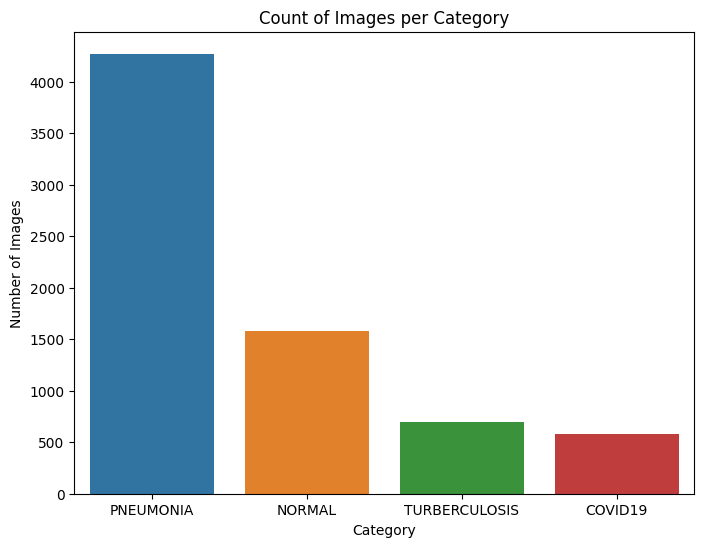

In [125]:
category_counts = df['category'].value_counts()

plt.figure(figsize=( 8, 6))

sns.barplot(x=category_counts.index, y=category_counts.values )

plt.title("Count of Images per Category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show()


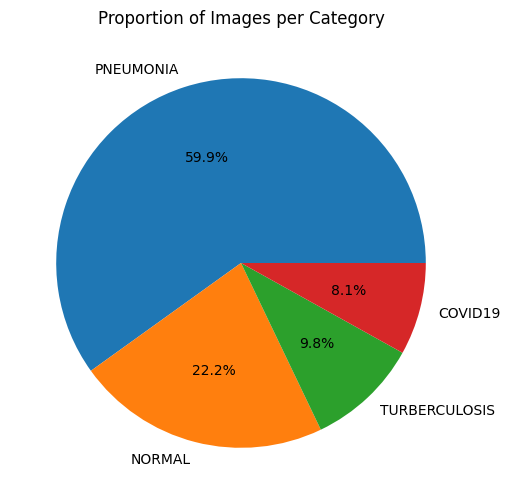

In [129]:
plt.figure(figsize=( 8, 6))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')

plt.title("Proportion of Images per Category")
plt.show()

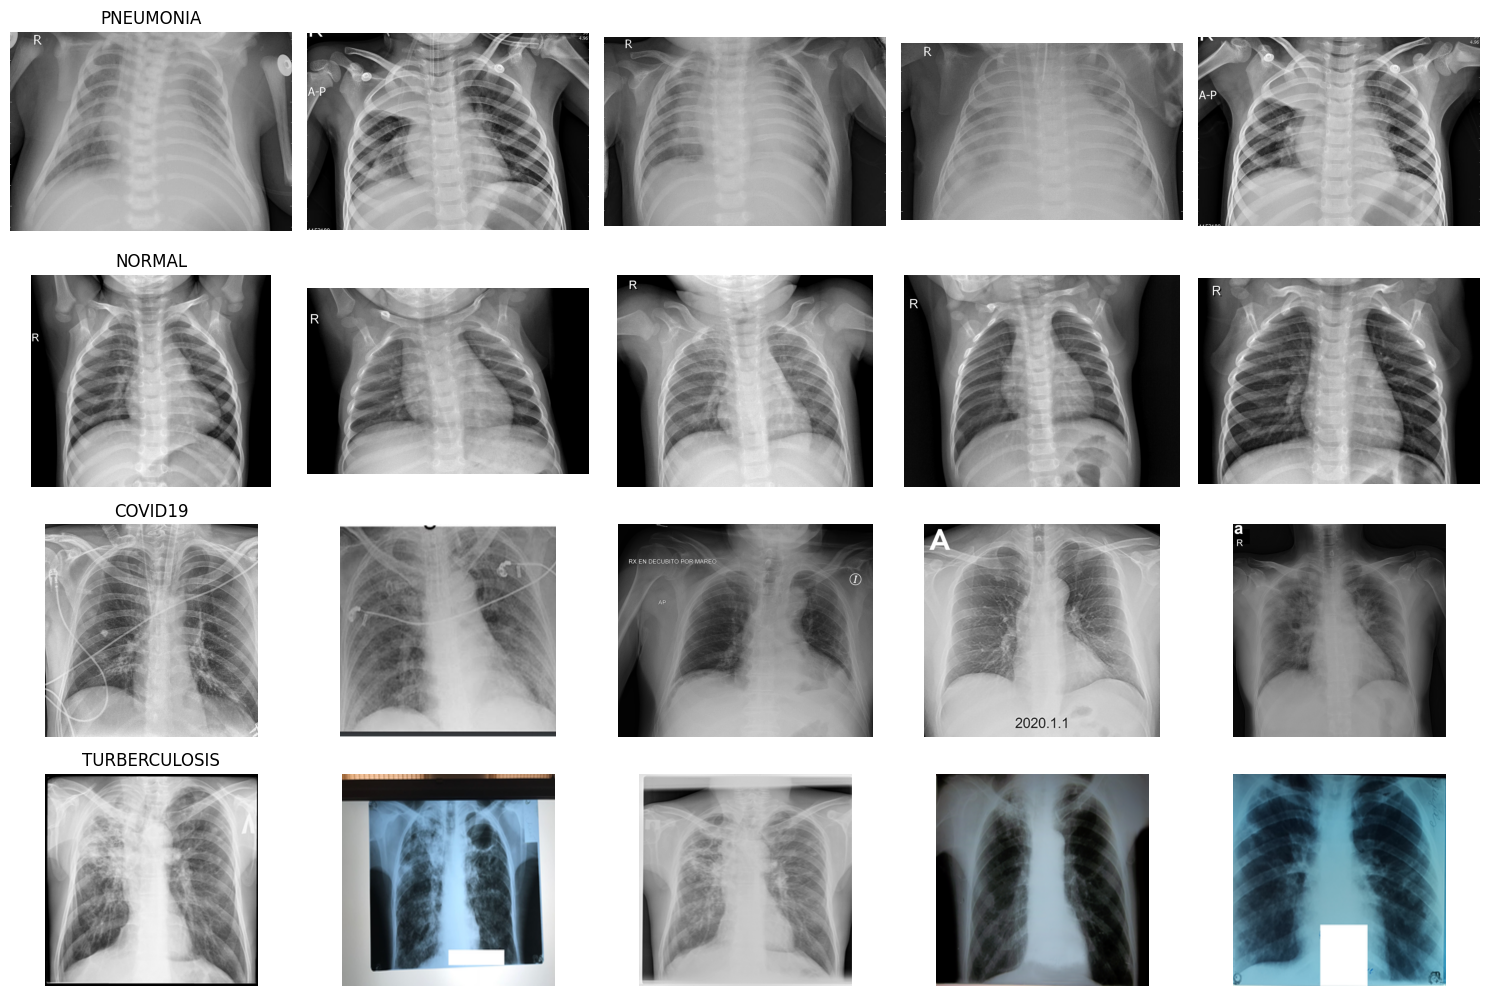

In [131]:
num_images_per_category = 5
plt.figure(figsize=( 15, 10))

for i, category in enumerate(df['category'].unique()):
     category_images = df[df['category'] == category]['image_path']
     selected_images = random.sample(list(category_images), num_images_per_category)
     for j, image_path in enumerate(selected_images):
        img = Image.open(image_path)
        plt.subplot(len(df[ 'category' ].unique()), num_images_per_category, i * num_images_per_category + j + 1)
        plt.imshow(img, cmap='gray' )
        plt.axis( 'off' )
        plt.title(category if j == 0 else "" )

plt.tight_layout()
plt.show()

# Data Preprocessing

In [133]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [135]:
df = df[['image_path' , 'category_encoded']]

ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(df[['image_path' ]], df['category_encoded'])

df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])

df_resampled['category_encoded'] = y_resampled

print(" \nClass distribution after oversampling:")
print(df_resampled[ 'category_encoded' ].value_counts())

 
Class distribution after oversampling:
category_encoded
2    4273
1    4273
0    4273
3    4273
Name: count, dtype: int64


In [137]:
df_resampled

,image_path,category_encoded
0,/kaggle/input/chest-x-ray-dataset-4-categories...,2
1,/kaggle/input/chest-x-ray-dataset-4-categories...,2
2,/kaggle/input/chest-x-ray-dataset-4-categories...,2
3,/kaggle/input/chest-x-ray-dataset-4-categories...,2
4,/kaggle/input/chest-x-ray-dataset-4-categories...,2
...,...,...
17087,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17088,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17089,/kaggle/input/chest-x-ray-dataset-4-categories...,3
17090,/kaggle/input/chest-x-ray-dataset-4-categories...,3


In [141]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype( str)

train_df_new, temp_df_new = train_test_split(df_resampled, train_size=0.8, shuffle=True, random_state=42, stratify=df_resampled[ 'category_encoded' ])

valid_df_new, test_df_new = train_test_split(temp_df_new,test_size=0.5,shuffle=True,random_state=42,stratify=temp_df_new[ 'category_encoded' ])

In [142]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path' ,
    y_col='category_encoded' ,
    target_size=img_size,
    class_mode='sparse' ,
    color_mode='rgb' ,
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path' ,
    y_col='category_encoded' ,
    target_size=img_size,
    class_mode='sparse' ,
    color_mode='rgb' ,
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path' ,
    y_col='category_encoded' ,
    target_size=img_size,
    class_mode='sparse' ,
    color_mode='rgb' ,
    shuffle=False,
    batch_size=batch_size
)

Found 13673 validated image filenames belonging to 4 classes.
Found 1709 validated image filenames belonging to 4 classes.
Found 1710 validated image filenames belonging to 4 classes.


# Custom Functions

# Define Model

In [148]:
def create_vgg19_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = VGG19(weights='imagenet', input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    height, width, channels = 7, 7, 512
    
    x = Reshape((height * width, channels))(x)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=channels)(x, x)
    attention_output = Reshape((height, width, channels))(attention_output)
    
    x = GaussianNoise(0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu' )(x)
    x = BatchNormalization()(x)
    x = GaussianNoise( 0.25)(x)
    x = Dropout(0.25)(x)
 
    outputs = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [149]:
input_shape = (224, 224, 3)
cnn_model = create_vgg19_model(input_shape)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Compile and Fit

In [146]:
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")
 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Using CPU


In [ ]:
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy' ,metrics=[ 'accuracy' ])

history = cnn_model.fit(
 train_gen_new,
 validation_data=valid_gen_new,
 epochs=1,
 callbacks=[early_stopping],
 verbose=1
)

# Visualization of model

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train' , 'Validation'], loc='upper left')

plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train' , 'Validation'], loc='upper left')
plt.show()

# Evaluation

In [ ]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
report = classification_report(test_labels, predicted_classes,target_names=list(test_gen_new.class_indices.keys()))
print(report)

In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=( 10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d' , cmap='Blues' , xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Part Two**

In [ ]:
def create_mobilenet_model(input_shape):
    inputs = Input(shape=input_shape)
    base_model = MobileNet(weights='imagenet' , input_tensor=inputs, include_top=False)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    height, width, channels = 7, 7, 1024
    x = Reshape((height * width, channels))(x)
    
    attention_output = MultiHeadAttention(num_heads=8,key_dim=channels)(x, x)
    attention_output = Reshape((height, width, channels))(attention_output)
 
    x = GaussianNoise( 0.25)(attention_output)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu' )(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.25)(x)
    x = Dropout(0.25)(x)
    outputs = Dense(4, activation='softmax' )(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
input_shape = ( 224, 224, 3)
cnn_model = create_mobilenet_model(input_shape)

In [ ]:
cnn_model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
 train_gen_new,
 validation_data=valid_gen_new,
 epochs=1,
 callbacks=[early_stopping],
 verbose=1
)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train' , 'Validation'], loc='upper left' )
plt.show()

plt.plot(history.histohistoryry['loss'])
plt.plot(history.['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

In [ ]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=( 10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d' , cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))

plt.title( 'Confusion Matrix' )
plt.xlabel( 'Predicted Label' )
plt.ylabel( 'True Label' )
plt.show()

In [ ]:
data = {
 'Model' : [ 'VGG19' , 'VGG19' , 'VGG19' , 'VGG19' , 'MobileNet' , 'MobileNet' , 'MobileNet' , 'MobileNet' ],
 'Class' : [ 'Class 0' , 'Class 1' , 'Class 2' , 'Class 3' , 'Class 0' , 'Class 1' , 'Class 2' , 'Class 3' ],
 'Precision' : [ 0.99, 0.98, 0.95, 1.00, 1.00, 0.98, 0.97, 1.00],
 'Recall' : [ 1.00, 0.95, 0.98, 1.00, 1.00, 0.97, 0.98, 1.00],
 'F1-Score' : [ 1.00, 0.96, 0.96, 1.00, 1.00, 0.97, 0.98, 1.00]
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

def annotate_bars(ax):
    for p in ax.patches:
        ax.annotate( f' {p. get_height() :.2f}' , (p.get_x() + p.get_width() / 2. , p.get_height()), ha='center' , va='bottom' , fontsize=10, color='black' )

sns.barplot(data=df, x='Class' , y='Precision' , hue='Model' , ax=ax[ 0])

ax[0].set_title('Precision by Class')
ax[0].set_ylim( 0.9, 1.05)
annotate_bars(ax[ 0])

sns.barplot(data=df, x='Class' , y='Recall' , hue='Model' , ax=ax[ 1])
ax[ 1].set_title('Recall by Class')
ax[ 1].set_ylim( 0.9, 1.05)
annotate_bars(ax[1])

sns.barplot(data=df, x='Class' , y='F1-Score' , hue='Model' , ax=ax[ 2])
ax[ 2].set_title('F1-Score by Class')
ax[ 2].set_ylim( 0.9, 1.05)
annotate_bars(ax[2])

plt.suptitle('Comparison of VGG19 vs MobileNet with Attention')
plt.tight_layout(rect=[ 0, 0.03, 1, 0.95])
plt.show()